## Training with TELSEM emissivity

Using windsat grid

In [1]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model

import sys
import os
sys.path.append("../../")

from src.processing import windsat_datacube, model_preprocess, \
    telsem_datacube, doy2month_mapping
from src.model import xy_split, plot_history


# Global variables
swath = 1

swath2char = {
    0 : "A", # Ascensing pass (6 PM)
    1 : "D", # Descending pass (6 Am)
}

# Paths 
models_folder = "../../models/"


In [2]:
#Load the windsat dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
swath_ds= model_preprocess(ds, swath_sector=swath, look="impute", add_look_flag=False) 
swath_ds

<xarray.Dataset> Size: 896MB
Dimensions:         (day_number: 24, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
# Load telsem emissivity atlas (preprocessed)
telsem_folder = "../../data/processed/WindsatEmiss/"
telsem_ds = telsem_datacube(telsem_folder)
telsem_ds

<xarray.Dataset> Size: 398MB
Dimensions:  (month: 12, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * month    (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: latitude_grid, longitude_grid
Data variables:
    Emis19V  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis19H  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37V  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37H  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    lat      (month, latitude_grid) float32 35kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    lon      (month, longitude_grid) float32 69kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [4]:
# Create an atlas dataframe with all the months:
telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")
telsem_df

month   Emis19V   Emis19H   Emis37V   Emis37H  \
latitude_grid longitude_grid                                                  
4             0                   1  0.838461  0.642331  0.850453  0.687476   
              1                   1  0.838612  0.642670  0.850646  0.687777   
              2                   1  0.838762  0.643009  0.850838  0.688078   
              3                   1  0.838912  0.643348  0.851031  0.688379   
              4                   1  0.839063  0.643688  0.851224  0.688679   
...                             ...       ...       ...       ...       ...   
693           609                12  0.929797  0.854530  0.850951  0.786876   
              610                12  0.929314  0.854520  0.845948  0.783754   
              611                12  0.928832  0.854509  0.840944  0.780632   
              612                12  0.929997  0.855679  0.836587  0.777149   
694           589                12  0.918187  0.844714  0.832307  0.772072   

                                 lat      lon  
latitude_grid longitude_grid                   
4             0              -88.875  180.125  
              1              -88.875  180.375  
              2              -88.875  180.625  
              3              -88.875  180.875  
              4              -88.875  181.125  
...                              ...      ...  
693           609             83.375  332.375  
              610             83.375  332.625  
              611             83.375  332.875  
              612             83.375  333.125  
694           589             83.625  327.375  

[4051772 rows x 7 columns]

In [5]:
# Simillarly with windsat data

# Select the necessary dvars
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]

swath_ds = swath_ds[d_vars]

swath_df = swath_ds.to_dataframe().dropna().reset_index("day_number")
swath_df

day_number  surtep_ERA5     lat      lon  \
latitude_grid longitude_grid                                             
136           448                      1   281.670471 -55.875  292.125   
137           447                      1   281.703644 -55.625  291.875   
138           442                      1   280.897614 -55.375  290.625   
              445                      1   281.388062 -55.375  291.375   
              446                      1   281.513428 -55.375  291.625   
...                                  ...          ...     ...      ...   
640           803                    349   275.467773  70.125   20.875   
642           808                    349   279.481720  70.625   22.125   
              809                    349   279.285858  70.625   22.375   
              810                    349   278.693848  70.625   22.625   
              811                    349   276.700043  70.625   22.875   

                              tbtoa_18Ghz_V  tbtoa_18Ghz_H  tbtoa_37Ghz_V  \
latitude_grid longitude_grid                                                
136           448                198.703393     133.243396     222.274487   
137           447                208.514965     150.382994     232.142393   
138           442                232.017487     196.492493     247.942505   
              445                235.268195     201.929346     249.889403   
              446                230.119642     190.062703     244.655528   
...                                     ...            ...            ...   
640           803                202.009995     141.417496     210.697495   
642           808                194.354996     123.147499     206.949997   
              809                201.444992     136.897491     209.597504   
              810                206.940002     148.145004     211.679993   
              811                209.517487     153.860001     212.699997   

                              tbtoa_37Ghz_H  
latitude_grid longitude_grid                 
136           448                172.835399  
137           447                190.532100  
138           442                224.702499  
              445                226.368030  
              446                214.429427  
...                                     ...  
640           803                159.542511  
642           808                146.887497  
              809                156.194992  
              810                163.494995  
              811                167.037506  

[1289282 rows x 8 columns]

In [6]:
# Map the day of the year (day_number) into the month:
day_mapping = doy2month_mapping()

swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")

swath_df

surtep_ERA5     lat      lon  tbtoa_18Ghz_V  \
latitude_grid longitude_grid                                                
136           448              281.670471 -55.875  292.125     198.703393   
137           447              281.703644 -55.625  291.875     208.514965   
138           442              280.897614 -55.375  290.625     232.017487   
              445              281.388062 -55.375  291.375     235.268195   
              446              281.513428 -55.375  291.625     230.119642   
...                                   ...     ...      ...            ...   
640           803              275.467773  70.125   20.875     202.009995   
642           808              279.481720  70.625   22.125     194.354996   
              809              279.285858  70.625   22.375     201.444992   
              810              278.693848  70.625   22.625     206.940002   
              811              276.700043  70.625   22.875     209.517487   

                              tbtoa_18Ghz_H  tbtoa_37Ghz_V  tbtoa_37Ghz_H  \
latitude_grid longitude_grid                                                
136           448                133.243396     222.274487     172.835399   
137           447                150.382994     232.142393     190.532100   
138           442                196.492493     247.942505     224.702499   
              445                201.929346     249.889403     226.368030   
              446                190.062703     244.655528     214.429427   
...                                     ...            ...            ...   
640           803                141.417496     210.697495     159.542511   
642           808                123.147499     206.949997     146.887497   
              809                136.897491     209.597504     156.194992   
              810                148.145004     211.679993     163.494995   
              811                153.860001     212.699997     167.037506   

                              month  
latitude_grid longitude_grid         
136           448                 1  
137           447                 1  
138           442                 1  
              445                 1  
              446                 1  
...                             ...  
640           803                12  
642           808                12  
              809                12  
              810                12  
              811                12  

[1289282 rows x 8 columns]

In [7]:
# Inner join the telsem dataframe and the swath dataframe.
combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,281.670471,-55.875,292.125,198.703393,133.243396,222.274487,172.835399,0.715009,0.504688,0.773820,0.580258
1,281.703644,-55.625,291.875,208.514965,150.382994,232.142393,190.532100,0.774127,0.605450,0.820554,0.666538
2,280.897614,-55.375,290.625,232.017487,196.492493,247.942505,224.702499,0.867672,0.764766,0.899219,0.819995
3,281.388062,-55.375,291.375,235.268195,201.929346,249.889403,226.368030,0.875530,0.783070,0.893727,0.812385
4,281.513428,-55.375,291.625,230.119642,190.062703,244.655528,214.429427,0.871065,0.774710,0.887698,0.799365
...,...,...,...,...,...,...,...,...,...,...,...
1289277,275.467773,70.125,20.875,202.009995,141.417496,210.697495,159.542511,0.665505,0.413298,0.703039,0.440390
1289278,279.481720,70.625,22.125,194.354996,123.147499,206.949997,146.887497,0.669632,0.419112,0.707013,0.448490
1289279,279.285858,70.625,22.375,201.444992,136.897491,209.597504,156.194992,0.670714,0.420704,0.707621,0.449943
1289280,278.693848,70.625,22.625,206.940002,148.145004,211.679993,163.494995,0.671796,0.422296,0.708228,0.451395


In [8]:
# Explicit model definition, to change it interactively.
def build_model(n_vars: int, info:bool = False):
    
    model = Sequential([
        Input((n_vars,)),
        BatchNormalization(),
        Dense(60,activation="linear", name = "hiddenLayer1"),
        Dense(30,activation="relu", name = "hiddenLayer2"),
        Dense(15,activation="relu", name = "hiddenLayer3"),
        Dense(1,activation="relu", name = "outputLayer")
    ])
    model.compile(
        optimizer = Adam(learning_rate=5e-4),
        loss ="mse",
        metrics = ["mse"]
    )

    if info:
        model.summary()

    return model

### NOTE: 
When removing coordinates, the training loss for the same model and training parameters went up a few kelvins,
it looks like the latitude and longitude are relevant training variables.

In [9]:
combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

In [10]:
# Now we can split the dataframe and train the model
X, y = xy_split(combined_df, y_column= "surtep_ERA5")
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 13)

model = build_model(n_vars=len(combined_df.columns) - 1, info=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 60)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 2,991 (11.68 KB)

 Non-trainable params: 20 (80.00 B)

In [11]:
# Callbacks
callbacks =[]

early_stopping = EarlyStopping(
    monitor = "loss",
    patience = 30,
    min_delta = 0.01,
    verbose=2,
    restore_best_weights = True
)
callbacks.append(early_stopping)

# checkpoints = ModelCheckpoint(
#     filepath = os.path.join(output_folder, "checkpoint.keras"),
#     verbose = 1
# )
# callbacks.append(checkpoints)

history = model.fit(
    x_train,
    y_train,
    epochs=300,
    batch_size = 512,
    validation_data=(x_test,y_test),
    callbacks=callbacks,
    verbose = 2
)

finished_at = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")


Epoch 1/300
1763/1763 - 3s - 2ms/step - loss: 16916.0020 - mse: 16916.0020 - val_loss: 128.5259 - val_mse: 128.5259
Epoch 2/300
1763/1763 - 2s - 1ms/step - loss: 35.3305 - mse: 35.3305 - val_loss: 13.1054 - val_mse: 13.1054
Epoch 3/300
1763/1763 - 2s - 1ms/step - loss: 12.5654 - mse: 12.5654 - val_loss: 11.9294 - val_mse: 11.9294
Epoch 4/300
1763/1763 - 2s - 1ms/step - loss: 12.2302 - mse: 12.2302 - val_loss: 11.8128 - val_mse: 11.8128
Epoch 5/300
1763/1763 - 2s - 1ms/step - loss: 12.1713 - mse: 12.1713 - val_loss: 11.6884 - val_mse: 11.6884
Epoch 6/300
1763/1763 - 2s - 1ms/step - loss: 11.9721 - mse: 11.9721 - val_loss: 12.3417 - val_mse: 12.3417
Epoch 7/300
1763/1763 - 2s - 1ms/step - loss: 11.7356 - mse: 11.7356 - val_loss: 11.0526 - val_mse: 11.0526
Epoch 8/300
1763/1763 - 2s - 1ms/step - loss: 11.4080 - mse: 11.4080 - val_loss: 10.9311 - val_mse: 10.9311
Epoch 9/300
1763/1763 - 2s - 1ms/step - loss: 11.2656 - mse: 11.2656 - val_loss: 10.7683 - val_mse: 10.7683
Epoch 10/300
1763/17

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K²])'>,
        <Axes: title={'center': 'Epochs after loss < 10'}, xlabel='Epoch', ylabel='mse [K²]'>],
       dtype=object))

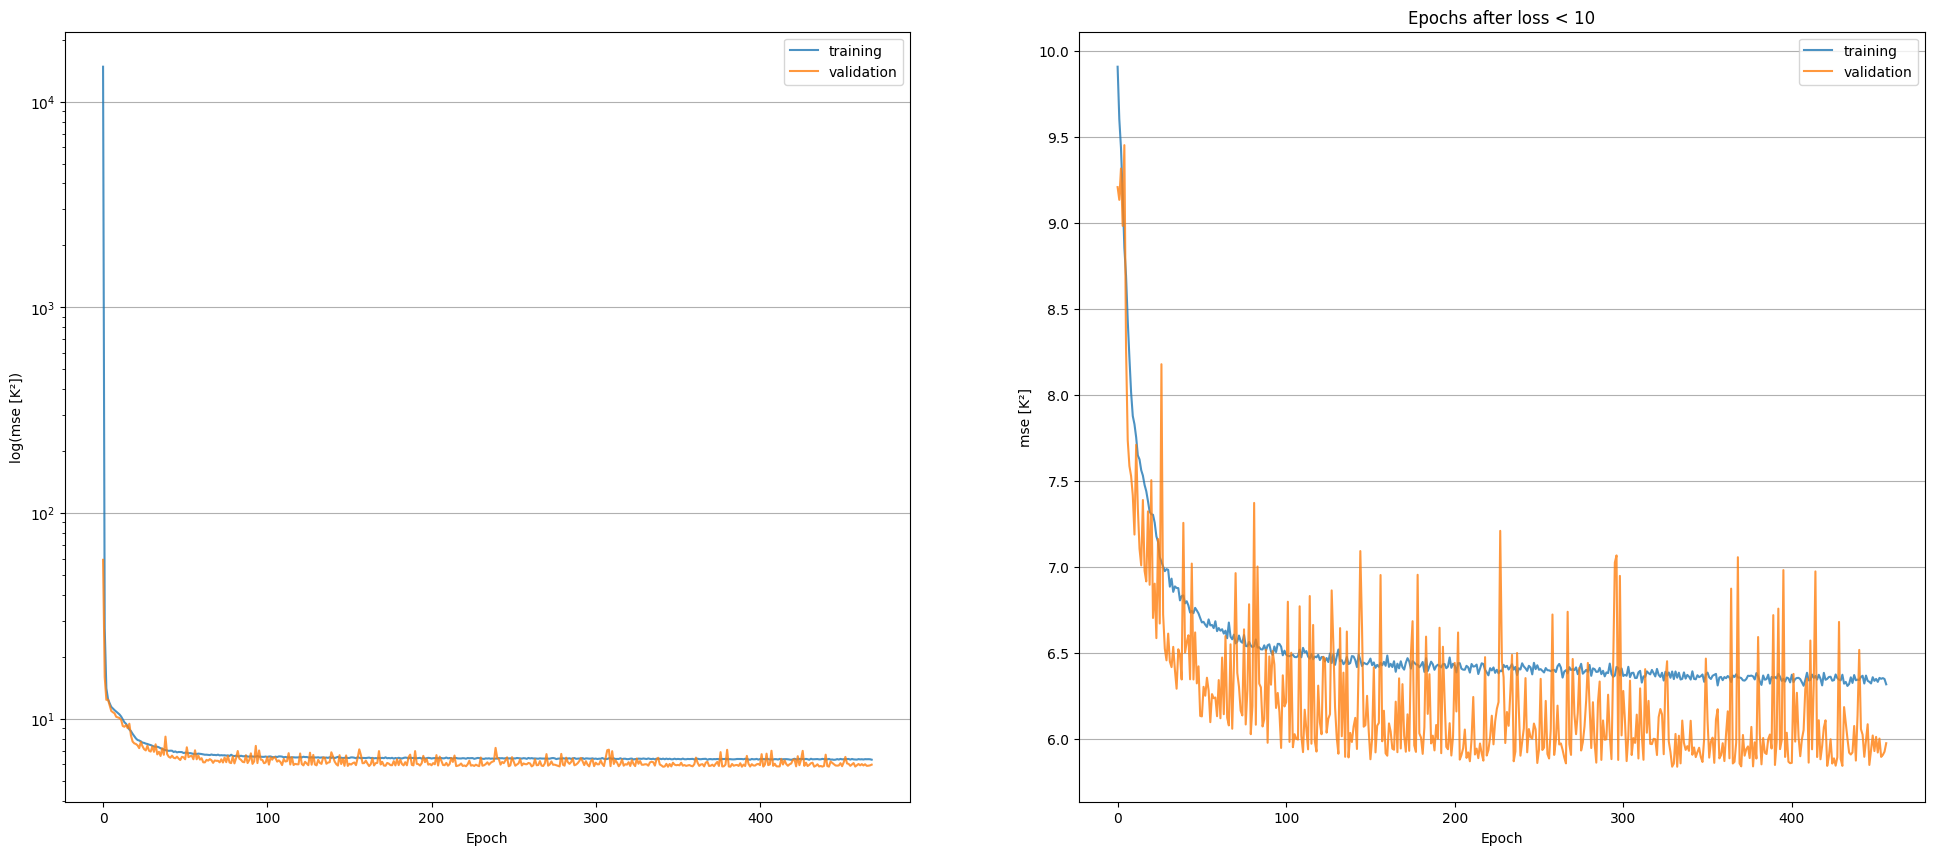

In [ ]:
plot_history(history.history, loss_threshold= 10)

In [ ]:
model_path = os.path.join(models_folder, f"local_windsatv2_{swath2char[swath]}_{finished_at}.keras")
save_model(model, model_path)

# Save the training history:s
history_path = os.path.join(models_folder, f"local_windsatv2_{swath2char[swath]}_{finished_at}_history")

with open(history_path,"wb") as hfile:
    pickle.dump(history.history, hfile)